In [1]:
!pip install -q keras
import keras
import keras.backend as K
from keras.layers.core import Activation
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM
from IPython.display import SVG, clear_output
from keras.utils import plot_model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

from sklearn import preprocessing

Using TensorFlow backend.


In [2]:
from google.colab import auth
from googleapiclient.discovery import build
import io , requests, os
import sys
auth.authenticate_user()
from googleapiclient.discovery import build
drive_service = build('drive', 'v3')
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [0]:

# Setting seed for reproducibility
np.random.seed(1234)  
PYTHONHASHSEED = 0

# define path to save model
model_path = '4regression_model.h5'

In [0]:


# read training data - It is the aircraft engine run-to-failure data.
file_id = '1UOECtQC5yrpUOSouIdjG6oWVena4T9Cy'
downloaded = drive.CreateFile({'id': file_id})
downloaded = drive.CreateFile({'id':'1UOECtQC5yrpUOSouIdjG6oWVena4T9Cy'}) # replace the id with id of file you want to access
downloaded.GetContentFile('train_FD001.txt')  
train_df = pd.read_csv('train_FD001.txt', sep=" ", header=None)
#print(train_df)
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']
train_df = train_df.sort_values(['id','cycle'])

# read test data - It is the aircraft engine operating data without failure events recorded.
file_id = '1-H8lW5mpu5LenbUfwP71MGWMh3aDZLCT'
downloaded = drive.CreateFile({'id': file_id})
downloaded = drive.CreateFile({'id':file_id}) # replace the id with id of file you want to access
downloaded.GetContentFile('test_FD001.txt')  
test_df = pd.read_csv('test_FD001.txt', sep=" ", header=None)
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

# read ground truth data - It contains the information of true remaining cycles for each engine in the testing data.
file_id = '1kcGQcTIPJiDWvDF4-TrHbF3YXjS7icwZ'
downloaded = drive.CreateFile({'id': file_id})
downloaded = drive.CreateFile({'id':file_id}) # replace the id with id of file you want to access
downloaded.GetContentFile('RUL_FD001.txt')  
truth_df = pd.read_csv('RUL_FD001.txt', sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)


In [5]:
# Data Labeling - generate column RUL
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
train_df = train_df.merge(rul, on=['id'], how='left')
train_df['RUL'] = train_df['max'] - train_df['cycle']
train_df.drop('max', axis=1, inplace=True)


# MinMax normalization
train_df['cycle_norm'] = train_df['cycle']
cols_normalize = train_df.columns.difference(['id','cycle','RUL'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_df.index)

join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)

/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [6]:
# MinMax normalization
test_df['cycle_norm'] = test_df['cycle']
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)
print(test_df.head())

# generate column max for test data
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth_df.columns = ['more']
truth_df['id'] = truth_df.index + 1
truth_df['max'] = rul['max'] + truth_df['more']
truth_df.drop('more', axis=1, inplace=True)

# generate RUL for test data
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)


   id  cycle  setting1  setting2  setting3        s1        s2        s3  \
0   1      1  0.476271  0.831354       1.0  0.626985  0.653479  0.643669   
1   1      2  0.595087  0.736342       0.0  0.238089  0.006793  0.036454   
2   1      3  0.999810  1.000000       1.0  0.000000  0.126216  0.263171   
3   1      4  0.999893  0.997862       1.0  0.000000  0.125849  0.262010   
4   1      5  0.833363  0.997625       1.0  0.060269  0.180099  0.298031   

         s4        s5     ...           s13       s14       s15  s16  \
0  0.488507  0.507937     ...      0.992533  0.488614  0.362278  0.0   
1  0.016957  0.293184     ...      0.001433  0.042513  0.929738  0.0   
2  0.195653  0.000000     ...      0.993001  0.541876  0.422161  0.0   
3  0.198967  0.000000     ...      0.992863  0.560536  0.409500  0.0   
4  0.224282  0.146592     ...      0.992781  0.509895  0.389988  0.0   

        s17       s18  s19       s20       s21  cycle_norm  
0  0.618557  0.864693  1.0  0.475950  0.484043   

In [0]:
# pick a large window size of 50 cycles
sequence_length = 50

def gen_sequence(id_df, seq_length, seq_cols):
   
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    
    # Iterate over two lists in parallel.
    # For example id1 have 192 rows so zip iterate over two following list of numbers (0,112),(50,192)
    # 0 50 from row 0 to row 50
    # 1 51 from row 1 to row 51
    # 2 52 from row 2 to row 52
    # ...
    # 111 191 from row 111 to 191
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_array[start:stop, :]
        

In [8]:
# pick the feature columns 
sensor_cols = ['s' + str(i) for i in range(1,22)]
sequence_cols = ['setting1', 'setting2', 'setting3', 'cycle_norm']
sequence_cols.extend(sensor_cols)

val=list(gen_sequence(train_df[train_df['id']==1], sequence_length, sequence_cols))
print(len(val))

# transform each id of the train dataset in a sequence
seq_gen = (list(gen_sequence(train_df[train_df['id']==id], sequence_length, sequence_cols)) 
           for id in train_df['id'].unique())

# generate sequences and convert to np array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
print(seq_array.shape)

271
(48799, 50, 25)


In [9]:
# generate labels
def gen_labels(id_df, seq_length, label):
   
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length:num_elements, :]

label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['RUL']) 
             for id in train_df['id'].unique()]

label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape


(48799, 1)

In [0]:
def r2_keras(y_true, y_pred):
   
    res =  K.sum(K.square( y_true - y_pred ))
    tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - res/(tot + K.epsilon()) )


In [0]:
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

In [12]:
# Next, we build a deep network. 
# The first layer ==> LSTM layer with 100 units
# Second Layer ==>  LSTM layer with 50 units. 
# Dropout is applied after each LSTM layer to control overfitting. 
# Final layer is a Dense output layer with single unit and Relu activation.
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

model = Sequential()
model.add(LSTM(
         input_shape=(sequence_length, nb_features),
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))

model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=nb_out))
model.add(Activation("linear"))
model.compile(loss='mean_squared_error', optimizer='rmsprop',metrics=['mae',r2_keras])

print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50, 100)           50400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 100)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 50, 32)            9632      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 25, 32)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                16600     
_________________________________________________________________
dropout_2 (Dropout)  

In [0]:
# plot
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []        
        self.fig = plt.figure()        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, np.sqrt(self.losses), label="loss")
        plt.plot(self.x, np.sqrt(self.val_losses), label="val_loss")
        plt.ylabel('loss - RMSE')
        plt.xlabel('epoch')
        plt.legend(['train','test'], loc='upper left')
        plt.title('model loss = ' + str(min(np.sqrt(self.val_losses))))
        plt.show();
        
plot_losses = PlotLosses()

In [0]:
# fit the network
history = model.fit(seq_array, label_array, epochs=100, batch_size=200, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          
                   )

# list all data in history
print(history.history.keys())


#history.save('lstm_rul.h5') 

Instructions for updating:
Use tf.cast instead.
Train on 46359 samples, validate on 2440 samples
Epoch 1/100
 - 33s - loss: 15884.2171 - mean_absolute_error: 98.8040 - r2_keras: -1.5327e+00 - val_loss: 12434.5180 - val_mean_absolute_error: 86.8651 - val_r2_keras: -2.0885e+00
Epoch 2/100
 - 26s - loss: 13882.3253 - mean_absolute_error: 90.1275 - r2_keras: -1.2129e+00 - val_loss: 10715.6828 - val_mean_absolute_error: 79.0402 - val_r2_keras: -1.6033e+00
Epoch 3/100
 - 27s - loss: 12112.2941 - mean_absolute_error: 82.6425 - r2_keras: -9.3160e-01 - val_loss: 9225.0451 - val_mean_absolute_error: 72.4383 - val_r2_keras: -1.2249e+00
Epoch 4/100
 - 26s - loss: 10575.0821 - mean_absolute_error: 76.3348 - r2_keras: -6.8247e-01 - val_loss: 7972.9937 - val_mean_absolute_error: 67.1075 - val_r2_keras: -9.5607e-01
Epoch 5/100
 - 26s - loss: 9281.2427 - mean_absolute_error: 71.2543 - r2_keras: -4.7494e-01 - val_loss: 6962.0385 - val_mean_absolute_error: 63.0558 - val_r2_keras: -7.9707e-01
Epoch 6/100


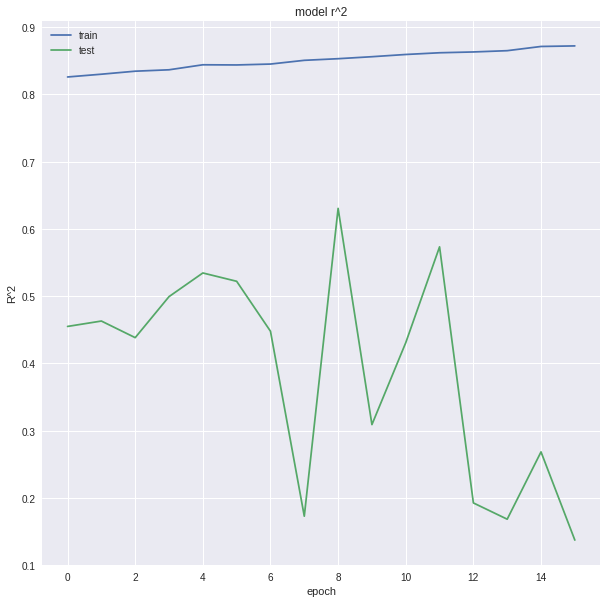

In [0]:
# summarize for R^2
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['r2_keras'])
plt.plot(history.history['val_r2_keras'])
plt.title('model r^2')
plt.ylabel('R^2')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("model_r2.png")

 

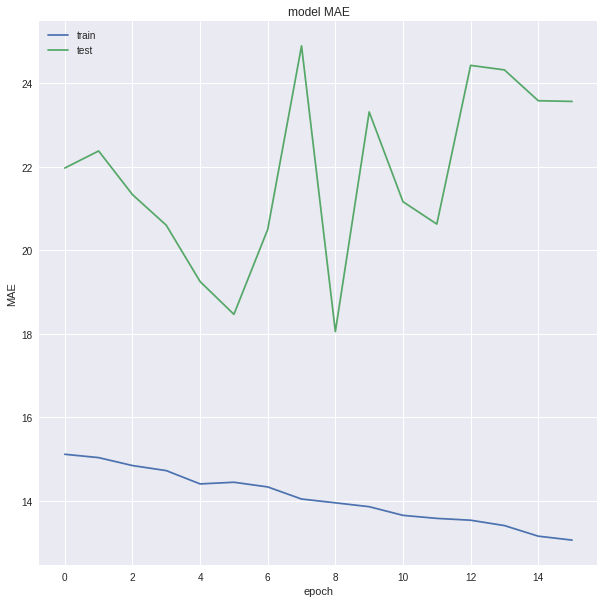

In [0]:

# summarize for MAE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("model_mae.png")

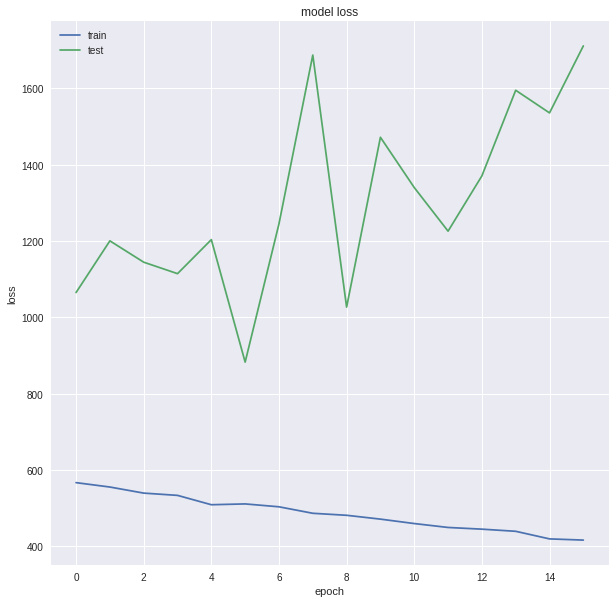

In [0]:
# summarize for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("model_regression_loss.png")


In [0]:

# training metrics
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('\nMAE: {}'.format(scores[1]))
print('\nR^2: {}'.format(scores[2]))

15631/15631 [==============================] - 3s 181us/step

MAE: 12.9285489009

R^2: 0.786309136412


In [0]:

# training metrics
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('\nMAE: {}'.format(scores[1]))
print('\nR^2: {}'.format(scores[2]))

15631/15631 [==============================] - 3s 179us/step

MAE: 12.9285489009

R^2: 0.786309136412


In [0]:
y_pred = model.predict(seq_array,verbose=1, batch_size=200)
y_true = label_array
submit = np.concatenate((y_pred, y_true), axis=1)
print(submit)

test_set = pd.DataFrame(y_pred)
test_set.to_csv('submit_train.csv', index = None)


15631/15631 [==============================] - 3s 169us/step
[[144.20877   141.       ]
 [156.09735   140.       ]
 [161.80191   139.       ]
 ...
 [  3.1130104   2.       ]
 [  2.6303213   1.       ]
 [  2.360741    0.       ]]


In [0]:
# We pick the last sequence for each id in the test data
seq_array_test_last = [test_df[test_df['id']==id][sequence_cols].values[-sequence_length:] 
                       for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
#print("seq_array_test_last")
#print(seq_array_test_last)
#print(seq_array_test_last)

# Similarly, we pick the labels
#print("y_mask")
y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]
label_array_test_last = test_df.groupby('id')['RUL'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)
print(label_array_test_last.shape)
print("label_array_test_last")
print(label_array_test_last)


(93, 1)
label_array_test_last
[[ 69.]
 [ 82.]
 [ 91.]
 [ 93.]
 [ 91.]
 [ 95.]
 [111.]
 [ 96.]
 [ 97.]
 [124.]
 [ 95.]
 [ 83.]
 [ 84.]
 [ 50.]
 [ 28.]
 [ 87.]
 [ 16.]
 [ 57.]
 [113.]
 [ 20.]
 [119.]
 [ 66.]
 [ 97.]
 [ 90.]
 [115.]
 [  8.]
 [ 48.]
 [106.]
 [  7.]
 [ 11.]
 [ 19.]
 [ 21.]
 [ 50.]
 [ 28.]
 [ 18.]
 [ 10.]
 [ 59.]
 [109.]
 [114.]
 [ 47.]
 [135.]
 [ 92.]
 [ 21.]
 [ 79.]
 [114.]
 [ 29.]
 [ 26.]
 [ 97.]
 [137.]
 [ 15.]
 [103.]
 [ 37.]
 [114.]
 [100.]
 [ 21.]
 [ 54.]
 [ 72.]
 [ 28.]
 [128.]
 [ 14.]
 [ 77.]
 [  8.]
 [121.]
 [ 94.]
 [118.]
 [ 50.]
 [131.]
 [126.]
 [113.]
 [ 10.]
 [ 34.]
 [107.]
 [ 63.]
 [ 90.]
 [  8.]
 [  9.]
 [137.]
 [ 58.]
 [ 89.]
 [116.]
 [115.]
 [136.]
 [ 28.]
 [ 38.]
 [ 20.]
 [ 85.]
 [ 55.]
 [128.]
 [137.]
 [ 82.]
 [ 59.]
 [117.]
 [ 20.]]


In [0]:
def score_cal(y_hat, Y_test):
    d   = y_hat - Y_test
    tmp = np.zeros(d.shape[0])
    for i in range(d.shape[0]):
        if d[i,0] >= 0:
           tmp[i] = np.exp( d[i,0]/10) - 1
        else:
           tmp[i] = np.exp(-d[i,0]/13) - 1
    return tmp 


MAE: 15.0277278449

R^2: 0.715247673373
[[ 69.         52.003536 ]
 [ 82.         83.94458  ]
 [ 91.         75.21158  ]
 [ 93.        117.94468  ]
 [ 91.        114.06082  ]
 [ 95.        109.48295  ]
 [111.        125.30091  ]
 [ 96.         81.50899  ]
 [ 97.         80.96922  ]
 [124.        106.52848  ]
 [ 95.         89.55641  ]
 [ 83.        124.89414  ]
 [ 84.        111.58367  ]
 [ 50.         52.45282  ]
 [ 28.         33.474483 ]
 [ 87.         80.44145  ]
 [ 16.         13.537309 ]
 [ 57.         71.897064 ]
 [113.        132.1286   ]
 [ 20.         16.702438 ]
 [119.        107.995476 ]
 [ 66.         83.897835 ]
 [ 97.        129.66705  ]
 [ 90.        101.31055  ]
 [115.         92.10761  ]
 [  8.          4.309177 ]
 [ 48.         39.70042  ]
 [106.        128.38707  ]
 [  7.          4.6352367]
 [ 11.         10.077182 ]
 [ 19.         17.66829  ]
 [ 21.         21.601154 ]
 [ 50.         56.0236   ]
 [ 28.         19.847067 ]
 [ 18.         18.80662  ]
 [ 10.        

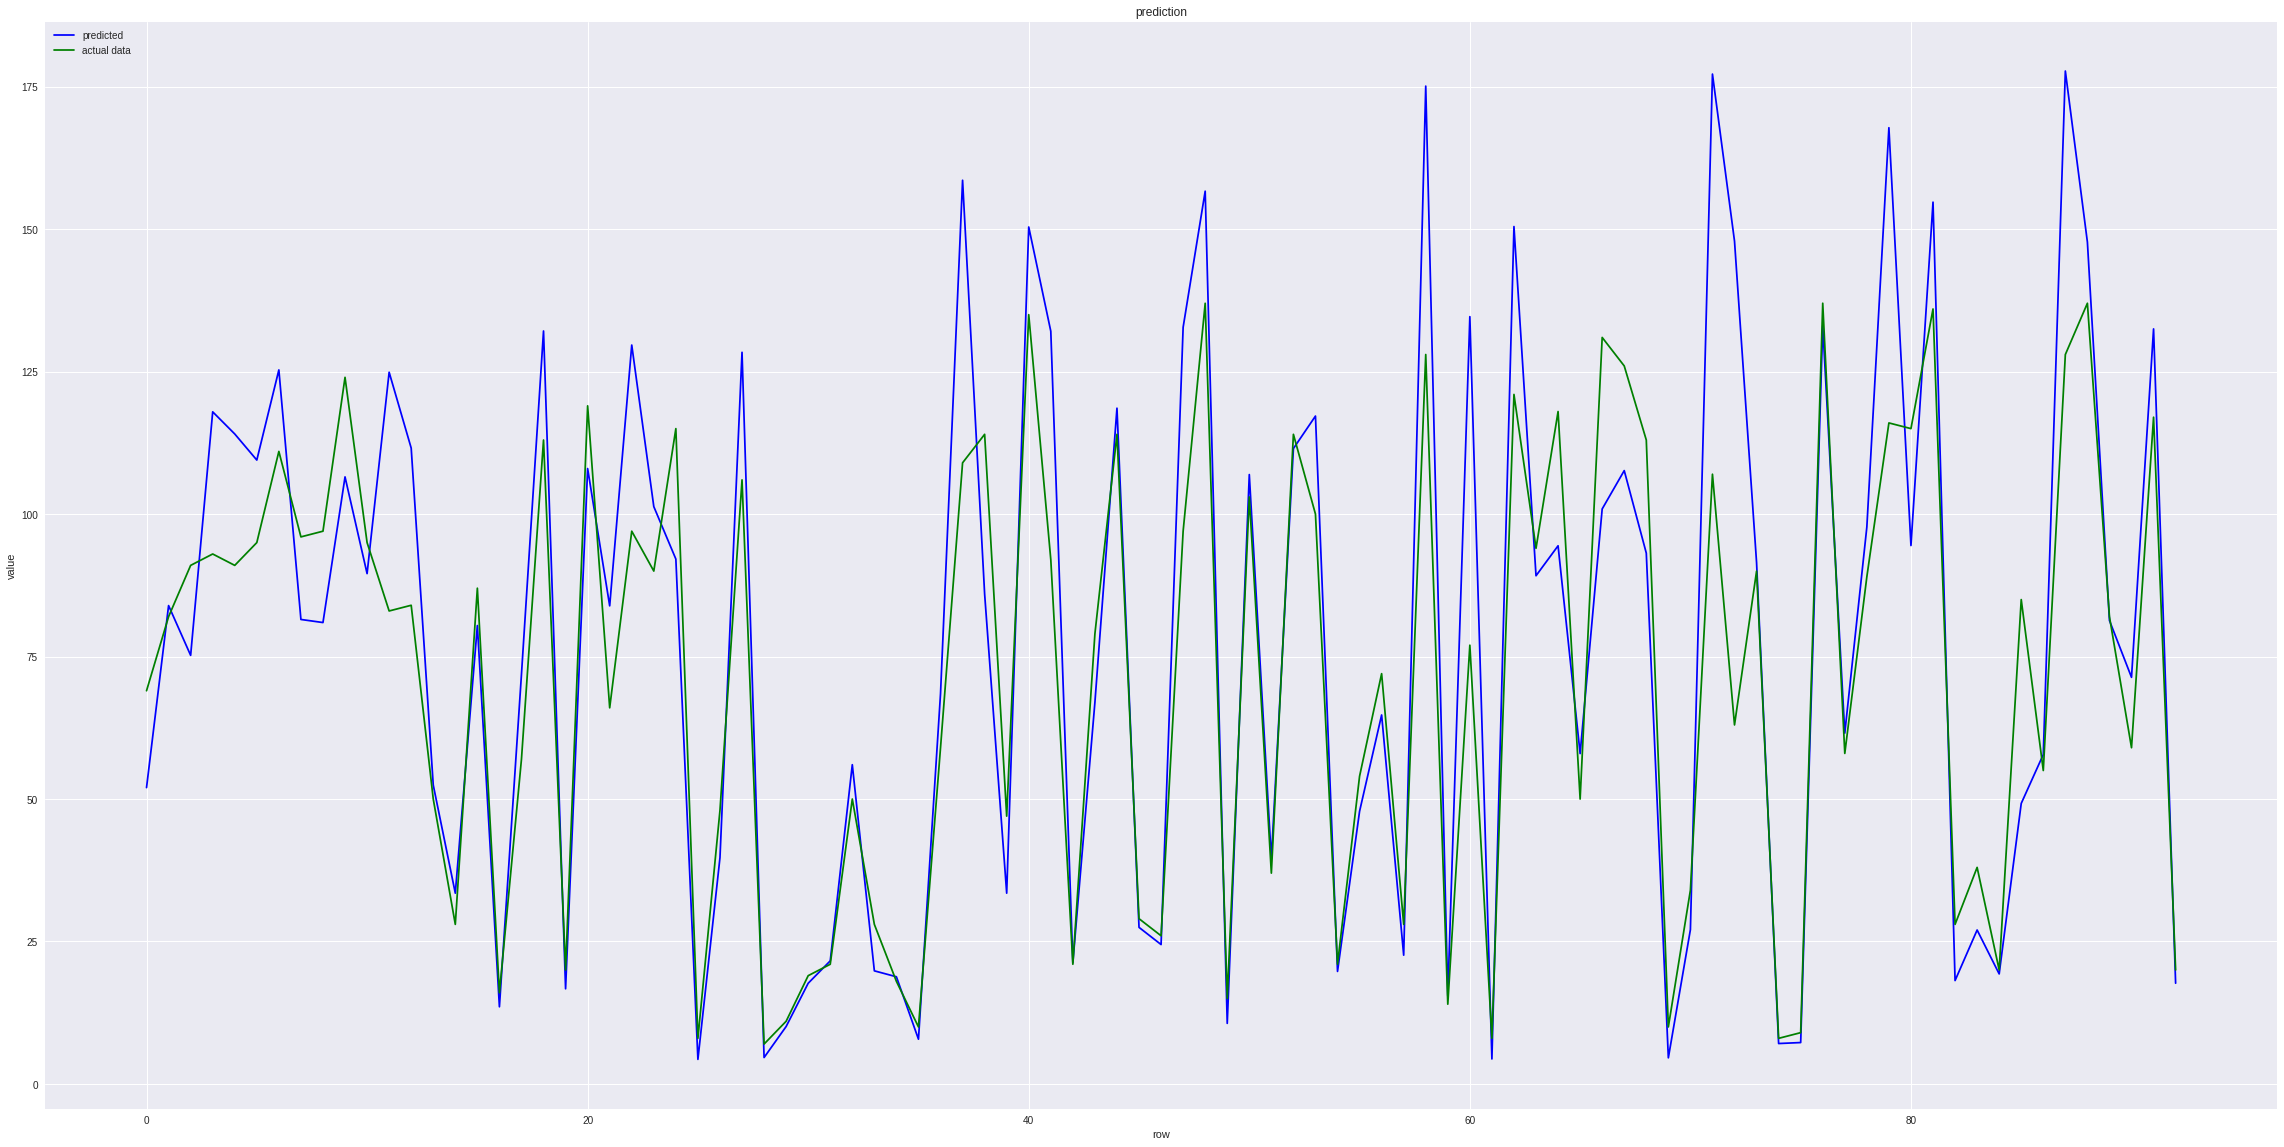

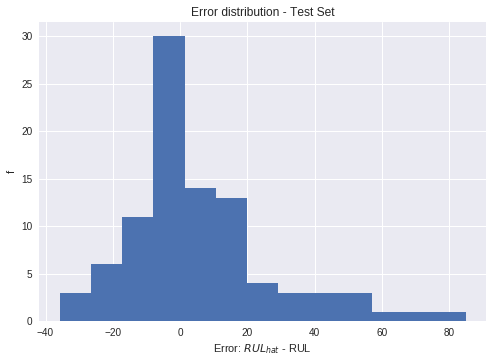

Score = 7253.144027766835


In [0]:
# if best iteration's model was saved then load and use it
if os.path.isfile(model_path):
    estimator = load_model(model_path,custom_objects={'r2_keras': r2_keras})

    # test metrics
    scores_test = estimator.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
    print('\nMAE: {}'.format(scores_test[1]))
    print('\nR^2: {}'.format(scores_test[2]))

    y_pred_test = estimator.predict(seq_array_test_last)
    y_true_test = label_array_test_last

    test_set = pd.DataFrame(y_pred_test)
    submit = np.concatenate((y_true_test, y_pred_test), axis=1)
    print(submit)
    test_set.to_csv('submit_test.csv', index = None)

    # Plot in blue color the predicted data and in green color the
    # actual data to verify visually the accuracy of the model.
    fig_verify = plt.figure(figsize=(40, 20))
    plt.plot(y_pred_test, color="blue")
    plt.plot(y_true_test, color="green")
    plt.title('prediction')
    plt.ylabel('value')
    plt.xlabel('row')
    plt.legend(['predicted', 'actual data'], loc='upper left')
    plt.show()
    fig_verify.savefig("model_regression_verify.png")
    
    d = y_pred_test - y_true_test
    plt.hist(d, bins='auto')  
    plt.title('Error distribution - Test Set')
    plt.ylabel('f')
    plt.xlabel("Error: $RUL_{hat}$ - RUL")
    plt.show()
    
    score_i_tr = score_cal(y_pred_test, y_true_test)
    print("Score = " + str(sum(score_i_tr)))